In [1]:
import matplotlib.pyplot as plt
import numpy as np

from utils.data_preprocessing import (
    compare_feature_statistics,
    moving_average_causal_filter,
)
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.plotting import (
    plot_all_data_results,
    plot_metric_results,
    plot_original_vs_processed_data,
)

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import json

with open("../conf.json", "r") as f:
    config = json.load(f)

In [4]:
###### Simulated data training #########

In [5]:
SEED = 42
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [6]:
EXP = "sim_b698"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,time
0,10.656969,16.801851,0.00
1,10.658275,16.802265,0.01
2,10.659582,16.802679,0.02
3,10.660889,16.803091,0.03
4,10.662196,16.803503,0.04


In [7]:
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(20000,)

In [8]:
SMOOTHING_WINDOW = config[EXP]["smoothing_window"]
DOWNSAMPLING_FACTOR = config[EXP]["downsampling_factor"]
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(9999,)

In [9]:
results = compare_feature_statistics(shear_stress_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': -0.005411611278037008,
  'p_value': 0.9956822159731284,
  'significant': False},
 'variance_comparison': {'f_statistic': 2.9285536623976996e-05,
  'p_value': 0.995682216006686,
  'significant': False}}

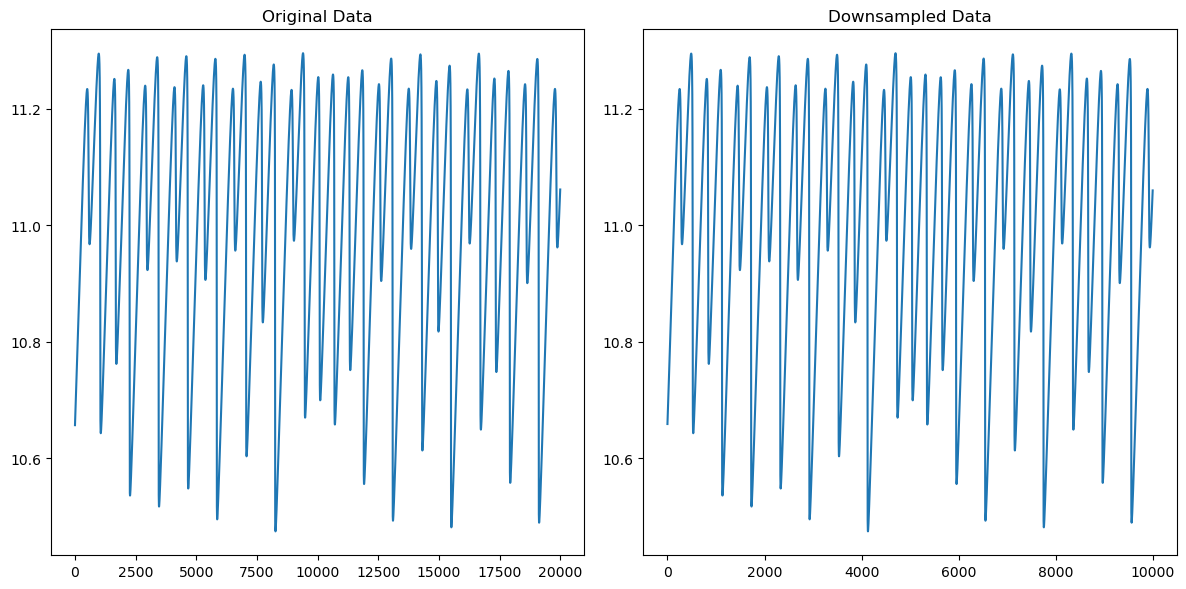

In [10]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "line", "Downsampled"
)

In [11]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import TemporalFusionTransformerEstimator

LOOKBACK, FORECAST = 300, 30
N_FORECAST_WINDOWS = 15

ts_data = pd.DataFrame(df_smoothed)
dummy_idx = pd.date_range("2024-01-01", periods=len(ts_data), freq="S")
ts_data = ts_data.set_index(dummy_idx)
dataset = PandasDataset(ts_data, target="obs_shear_stress")

test_size = N_FORECAST_WINDOWS * FORECAST
train_size = len(ts_data) - test_size

training_data, test_gen = split(dataset, offset=-test_size)
test_data = test_gen.generate_instances(
    prediction_length=FORECAST, windows=N_FORECAST_WINDOWS
)

In [12]:
model = TemporalFusionTransformerEstimator(
    prediction_length=FORECAST,
    freq="S",
    context_length=LOOKBACK,
    trainer_kwargs={"max_epochs": 10, "devices": 1},
).train(training_data)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/users/p341cam/miniconda3/envs/venv/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/gener

Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 1.25857 (best 1.25857), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_64/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.97593 (best 0.97593), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_64/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.55454 (best 0.55454), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_64/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 0.42065 (best 0.42065), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_64/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 0.39572 (best 0.39572), saving model to '/gws/nopw/

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

fcast = list(model.predict(test_data.input))
test_outputs = np.array([x["0.5"] for x in fcast]).reshape(-1)
test_iqr = np.array([0.5 * (x["0.9"] - x["0.1"]) for x in fcast]).reshape(-1)
test_rmse = np.sqrt(
    mean_squared_error(
        test_outputs, ts_data.iloc[train_size:]["obs_shear_stress"].values
    )
)

test_r2 = r2_score(
    test_outputs, ts_data.iloc[train_size:]["obs_shear_stress"].values
)
print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.1176, Test R^2: 0.7257


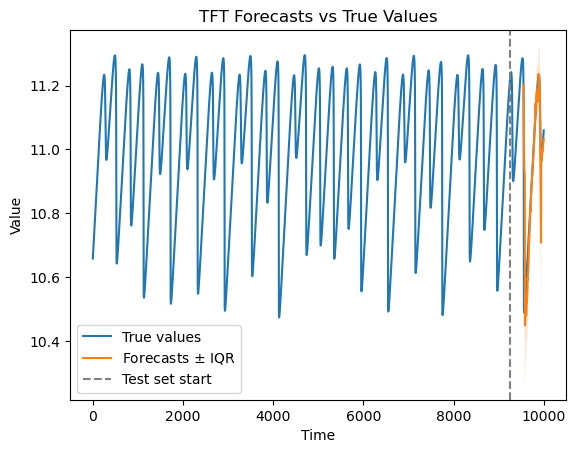

In [14]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)
train_iqr = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))
all_iqr = np.concatenate((train_iqr, test_iqr))

test_start_index = len(ts_data) - test_size - LOOKBACK

plt.plot(ts_data["obs_shear_stress"].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label=r"Forecasts $\pm$ IQR",
)
plt.fill_between(
    range(0, len(all_outputs)),
    all_outputs - all_iqr,
    all_outputs + all_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

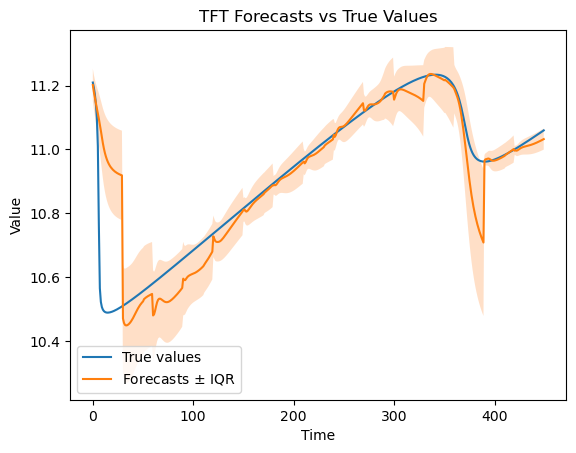

In [15]:
plt.plot(ts_data["obs_shear_stress"].values[-test_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label=r"Forecasts $\pm$ IQR",
)

plt.fill_between(
    range(0, test_size),
    test_outputs - test_iqr,
    test_outputs + test_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

In [16]:
###### Lab data training #########

In [17]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [18]:
EXP = "b698"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,obs_shear_stress,obs_normal_stress,obs_ecdisp,obs_shear_strain,time
0,11.225116,17.382861,20.088637,22.167371,0.00
1,11.222870,17.375571,20.088683,22.167447,0.01
2,11.224972,17.385328,20.088975,22.167941,0.02
3,11.221124,17.373017,20.088549,22.167221,0.03
4,11.225461,17.386512,20.089116,22.168180,0.04


In [19]:
shear_stress_df = df["obs_shear_stress"]
shear_stress_df.shape

(20001,)

In [20]:
SMOOTHING_WINDOW = config[EXP]["smoothing_window"]
DOWNSAMPLING_FACTOR = config[EXP]["downsampling_factor"]
df_smoothed = moving_average_causal_filter(
    shear_stress_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(10000,)

In [21]:
results = compare_feature_statistics(shear_stress_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.002753184281868637,
  'p_value': 0.9978032978502813,
  'significant': False},
 'variance_comparison': {'f_statistic': 7.580023683359035e-06,
  'p_value': 0.997803297844141,
  'significant': False}}

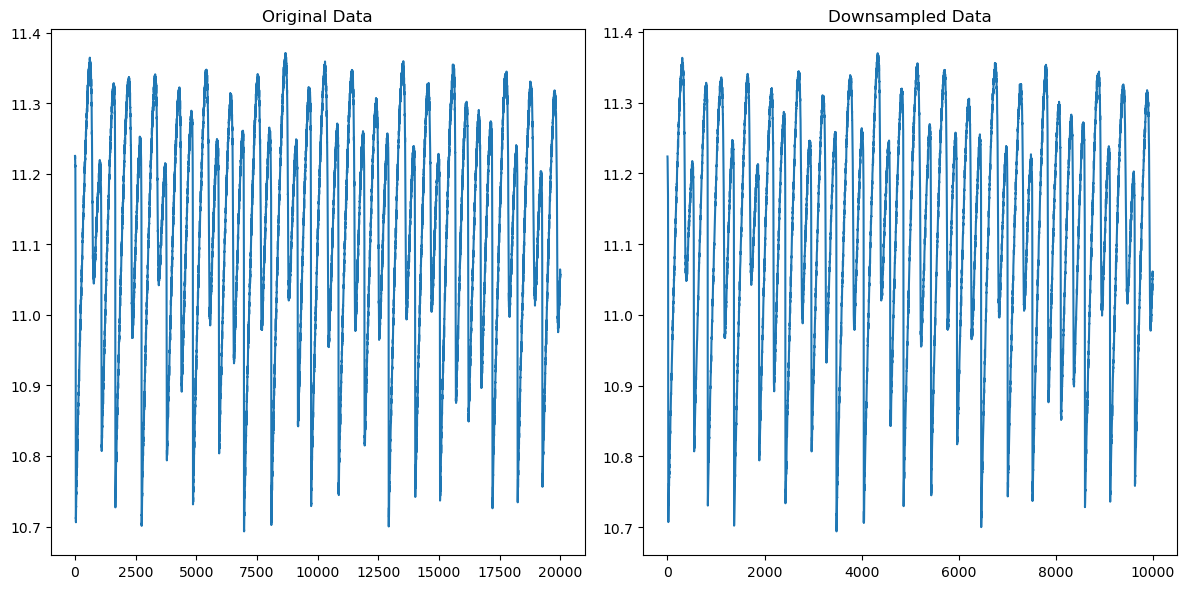

In [22]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "line", "Downsampled"
)

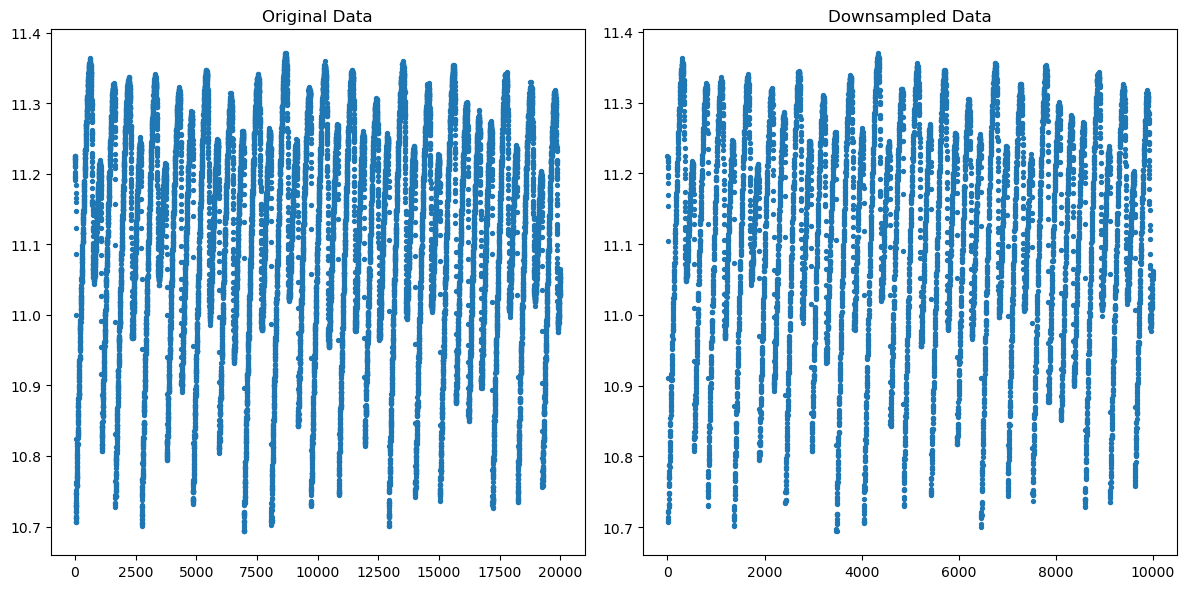

In [23]:
plot_original_vs_processed_data(
    shear_stress_df, df_smoothed, "scatter", "Downsampled"
)

In [24]:
ts_data = pd.DataFrame(df_smoothed)
dummy_idx = pd.date_range("2024-01-01", periods=len(ts_data), freq="S")
ts_data = ts_data.set_index(dummy_idx)
dataset = PandasDataset(ts_data, target="obs_shear_stress")

test_size = N_FORECAST_WINDOWS * FORECAST
train_size = len(ts_data) - test_size

training_data, test_gen = split(dataset, offset=-test_size)
test_data = test_gen.generate_instances(
    prediction_length=FORECAST, windows=N_FORECAST_WINDOWS
)

In [25]:
estimator = TemporalFusionTransformerEstimator(
    prediction_length=FORECAST,
    freq="S",
    context_length=LOOKBACK,
    trainer_kwargs={"max_epochs": 10, "devices": 1},
)

model_lab = estimator.train_model(training_data, from_predictor=model)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/users/p341cam/miniconda3/envs/venv/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                           | Params | In sizes                                                                                 | Out sizes 
-----------------------------------------------------------------------------------

Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 0.28157 (best 0.28157), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_65/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 0.21124 (best 0.21124), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_65/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 0.19102 (best 0.19102), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_65/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 0.18059 (best 0.18059), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_65/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' was

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

fcast = list(model_lab.predictor.predict(test_data.input))
test_outputs = np.array([x["0.5"] for x in fcast]).reshape(-1)
test_iqr = np.array([0.5 * (x["0.9"] - x["0.1"]) for x in fcast]).reshape(-1)
test_rmse = np.sqrt(
    mean_squared_error(
        test_outputs, ts_data.iloc[train_size:]["obs_shear_stress"].values
    )
)

test_r2 = r2_score(
    test_outputs, ts_data.iloc[train_size:]["obs_shear_stress"].values
)
print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.0716, Test R^2: 0.7618


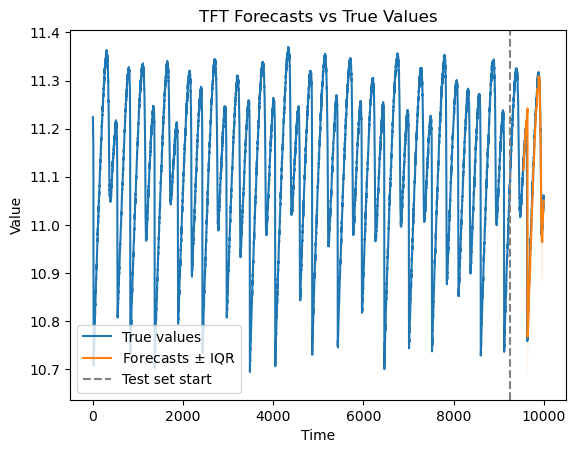

In [27]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)
train_iqr = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))
all_iqr = np.concatenate((train_iqr, test_iqr))

test_start_index = len(ts_data) - test_size - LOOKBACK

plt.plot(ts_data["obs_shear_stress"].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label=r"Forecasts $\pm$ IQR",
)
plt.fill_between(
    range(0, len(all_outputs)),
    all_outputs - all_iqr,
    all_outputs + all_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

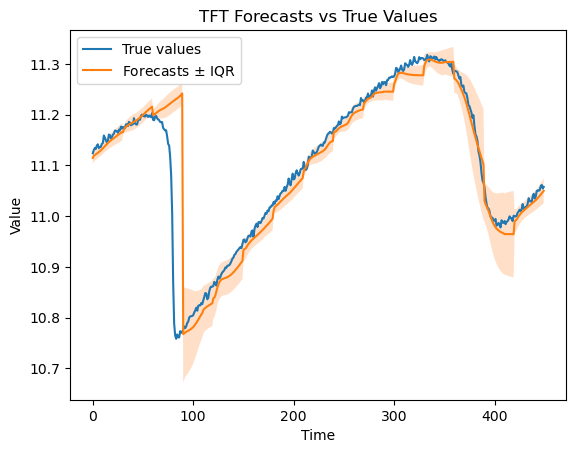

In [28]:
plt.plot(ts_data["obs_shear_stress"].values[-test_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label=r"Forecasts $\pm$ IQR",
)

plt.fill_between(
    range(0, test_size),
    test_outputs - test_iqr,
    test_outputs + test_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

In [29]:
###### Cascadia data training #########

In [30]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [31]:
EXP = "cascadia"

dataset = SlowEarthquakeDataset([EXP])
df = SlowEarthquakeDataset.convert_to_df(dataset, EXP)

df.head()

,seg_avg,seg_0,seg_1,seg_2,seg_3,seg_4,seg_5,seg_6,seg_7,seg_8,...,seg_187,seg_188,seg_189,seg_190,seg_191,seg_192,seg_193,seg_194,seg_195,time
0,1.510314e+08,87022.678176,-51216.196044,-195371.505863,-252388.298108,372090.056832,290238.755195,271991.646241,218795.685053,87096.609524,...,-714770.112748,-631423.743396,-693599.810348,-7.208255e+05,-739527.228854,-471014.225482,-6.757540e+05,-350155.612260,-517024.526987,2007.000700
1,1.256806e+08,118857.552212,64765.192887,-66943.170211,-125253.475061,510980.726973,375269.217942,323695.517273,312924.577753,-6911.497818,...,-506075.873333,-448764.275644,-391456.474306,-9.886575e+05,-958004.348328,-740390.446945,-8.927657e+05,-466337.939160,-928475.702850,2007.003438
2,1.074901e+08,-113120.619296,-100329.909243,-117236.092138,-63257.566664,87699.655400,15131.208777,-22576.356489,-13975.055467,-177396.925200,...,-421853.932989,-333693.022748,-204519.903296,-7.137062e+05,-715494.785171,-542145.799983,-6.803446e+05,-366915.287037,-572674.592498,2007.006176
3,1.447256e+08,-51897.143096,-61146.543996,-108560.424295,-80686.019435,178525.612880,98101.791008,48849.079713,53199.150697,-139909.026614,...,-655215.504038,-473799.573780,-345621.989210,-9.187762e+05,-927868.499626,-679886.516377,-8.823582e+05,-474262.121982,-695698.483285,2007.008914
4,1.787377e+08,-60139.943735,-118351.239477,-228181.280629,-226276.200039,270908.204014,154758.192851,92016.023222,86065.362414,-174784.005040,...,-916992.338832,-753637.001609,-546489.401328,-1.036981e+06,-934869.092836,-938970.117667,-1.106399e+06,-800182.900760,-897332.083419,2007.011651


In [32]:
segment_df = df["seg_avg"] / 1e8
segment_df.shape

(3883,)

In [33]:
SMOOTHING_WINDOW = config[EXP]["smoothing_window"]
DOWNSAMPLING_FACTOR = config[EXP]["downsampling_factor"]
df_smoothed = moving_average_causal_filter(
    segment_df, SMOOTHING_WINDOW, DOWNSAMPLING_FACTOR
)
df_smoothed.shape

(3874,)

In [34]:
results = compare_feature_statistics(segment_df, df_smoothed)
results

{'mean_comparison': {'t_statistic': 0.048536835802983076,
  'p_value': 0.961289658191594,
  'significant': False},
 'variance_comparison': {'f_statistic': 0.002355824429765806,
  'p_value': 0.9612896581873488,
  'significant': False}}

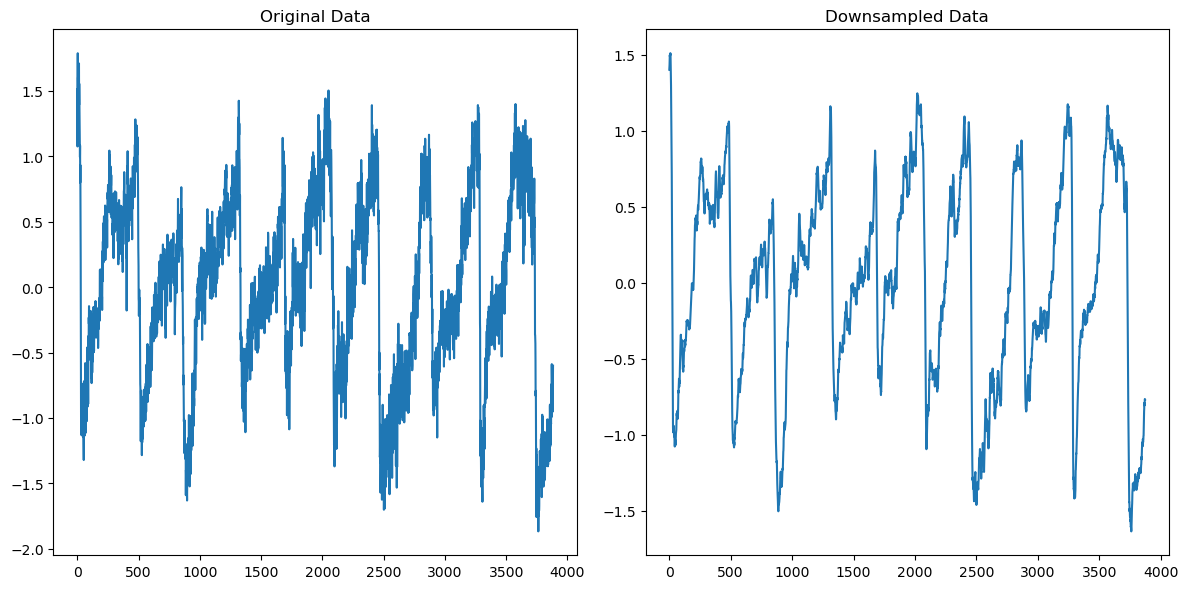

In [35]:
plot_original_vs_processed_data(segment_df, df_smoothed, "line", "Downsampled")

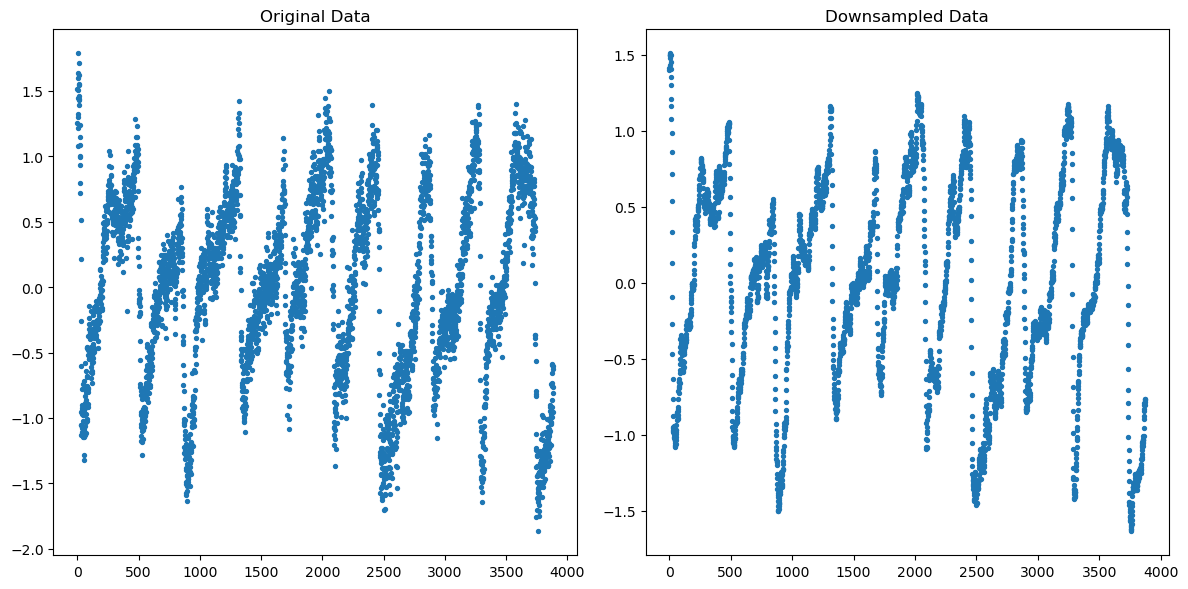

In [36]:
plot_original_vs_processed_data(
    segment_df, df_smoothed, "scatter", "Downsampled"
)

In [37]:
ts_data = pd.DataFrame(df_smoothed)
dummy_idx = pd.date_range("2024-01-01", periods=len(ts_data), freq="S")
ts_data = ts_data.set_index(dummy_idx)
dataset = PandasDataset(ts_data, target="seg_avg")

test_size = N_FORECAST_WINDOWS * FORECAST
train_size = len(ts_data) - test_size

training_data, test_gen = split(dataset, offset=-test_size)
test_data = test_gen.generate_instances(
    prediction_length=FORECAST, windows=N_FORECAST_WINDOWS
)

In [38]:
estimator = TemporalFusionTransformerEstimator(
    prediction_length=FORECAST,
    freq="S",
    context_length=LOOKBACK,
    trainer_kwargs={"max_epochs": 10, "devices": 1},
)

model_cascadia = estimator.train_model(
    training_data, from_predictor=model_lab.predictor
)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/users/p341cam/miniconda3/envs/venv/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                           | Params | In sizes                                                                                 | Out sizes 
-----------------------------------------------------------------------------------

Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 1.65220 (best 1.65220), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_66/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 1.34796 (best 1.34796), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_66/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 1.27813 (best 1.27813), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_66/checkpoints/epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 1.22099 (best 1.22099), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/

In [39]:
from sklearn.metrics import mean_squared_error, r2_score

fcast = list(model_cascadia.predictor.predict(test_data.input))
test_outputs = np.array([x["0.5"] for x in fcast]).reshape(-1)
test_iqr = np.array([0.5 * (x["0.9"] - x["0.1"]) for x in fcast]).reshape(-1)
test_rmse = np.sqrt(
    mean_squared_error(
        test_outputs, ts_data.iloc[train_size:]["seg_avg"].values
    )
)

test_r2 = r2_score(test_outputs, ts_data.iloc[train_size:]["seg_avg"].values)
print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.4653, Test R^2: 0.7170


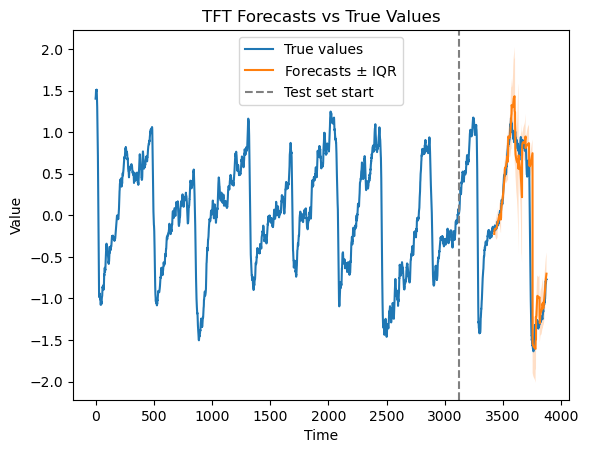

In [40]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)
train_iqr = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))
all_iqr = np.concatenate((train_iqr, test_iqr))

test_start_index = len(ts_data) - test_size - LOOKBACK

plt.plot(ts_data["seg_avg"].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label=r"Forecasts $\pm$ IQR",
)
plt.fill_between(
    range(0, len(all_outputs)),
    all_outputs - all_iqr,
    all_outputs + all_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

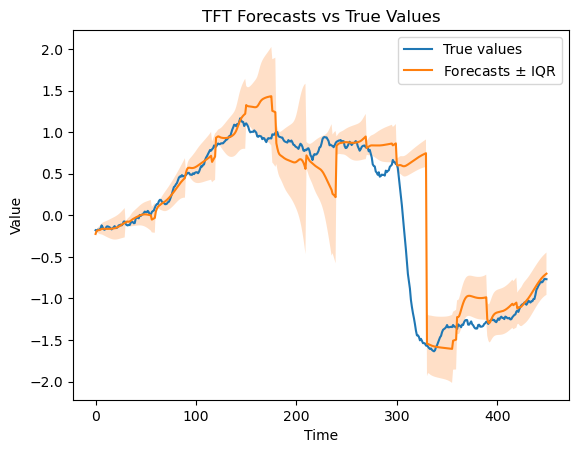

In [41]:
plt.plot(ts_data["seg_avg"].values[-test_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label=r"Forecasts $\pm$ IQR",
)

plt.fill_between(
    range(0, test_size),
    test_outputs - test_iqr,
    test_outputs + test_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

In [42]:
###### Regular Cascadia data training #########

In [43]:
set_seed(SEED)

device = set_torch_device()

GPU name: NVIDIA A100-SXM4-40GB
Max GPU memory: 42.297786368 GiB


In [44]:
model = TemporalFusionTransformerEstimator(
    prediction_length=FORECAST,
    freq="S",
    context_length=LOOKBACK,
    trainer_kwargs={"max_epochs": 10, "devices": 1},
).train(training_data)

/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/users/p341cam/miniconda3/envs/venv/lib/python3 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/users/p341cam/miniconda3/envs/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name  | Type                           | Params | In sizes                                                                                 | Out sizes 
-----------------------------------------------------------------------------------

Training: |                                                                                     | 0/? [00:00<?…

Epoch 0, global step 50: 'train_loss' reached 4.49414 (best 4.49414), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_67/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.30897 (best 3.30897), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_67/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.18882 (best 2.18882), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_67/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 1.82955 (best 1.82955), saving model to '/gws/nopw/j04/ai4er/users/pn341/earthquake-predictability/notebooks/lightning_logs/version_67/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 1.73345 (best 1.73345), saving model to '/gws/nopw/

In [45]:
from sklearn.metrics import mean_squared_error, r2_score

fcast = list(model.predict(test_data.input))
test_outputs = np.array([x["0.5"] for x in fcast]).reshape(-1)
test_iqr = np.array([0.5 * (x["0.9"] - x["0.1"]) for x in fcast]).reshape(-1)
test_rmse = np.sqrt(
    mean_squared_error(
        test_outputs, ts_data.iloc[train_size:]["seg_avg"].values
    )
)

test_r2 = r2_score(test_outputs, ts_data.iloc[train_size:]["seg_avg"].values)
print(f"Test RMSE: {test_rmse:.4f}, Test R^2: {test_r2:.4f}")

Test RMSE: 0.5264, Test R^2: 0.5006


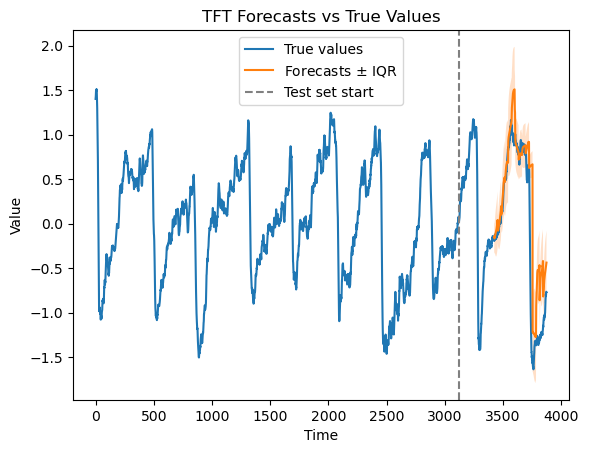

In [46]:
train_outputs = np.array([[np.nan] for x in range(train_size)]).reshape(-1)
train_iqr = np.array([[np.nan] for x in range(train_size)]).reshape(-1)

all_outputs = np.concatenate((train_outputs, test_outputs))
all_iqr = np.concatenate((train_iqr, test_iqr))

test_start_index = len(ts_data) - test_size - LOOKBACK

plt.plot(ts_data["seg_avg"].values, label="True values")
plt.plot(
    range(0, len(all_outputs)),
    all_outputs,
    label=r"Forecasts $\pm$ IQR",
)
plt.fill_between(
    range(0, len(all_outputs)),
    all_outputs - all_iqr,
    all_outputs + all_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.axvline(
    x=test_start_index, color="gray", linestyle="--", label="Test set start"
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()

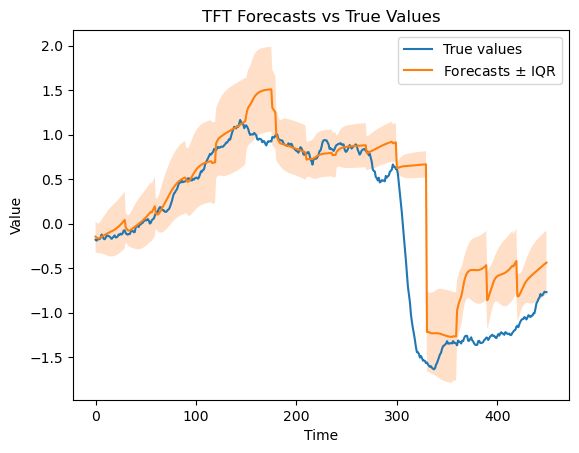

In [47]:
plt.plot(ts_data["seg_avg"].values[-test_size:], label="True values")
plt.plot(
    range(test_size),
    test_outputs,
    label=r"Forecasts $\pm$ IQR",
)

plt.fill_between(
    range(0, test_size),
    test_outputs - test_iqr,
    test_outputs + test_iqr,
    alpha=0.3,
    facecolor="#FF9848",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.title("TFT Forecasts vs True Values")
plt.show()